In [1]:
%matplotlib inline


In [2]:
# Import python modules
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
from shapely.geometry import Point
import gc, sys, os
sys.path.append("../scripts")
import spatial_functions
import aem_utils
import netcdf_utils
import plotting_functions as plots
import warnings
warnings.filterwarnings('ignore')

In [3]:
# The actual inversoin data are stored on disk as netcdf files. NetCDF is an efficient format for storing
# self-describing containerised data.
# The implementation of netcdf for AEM line data was done by Alex Ip using his geophys_utils package.
# https://github.com/GeoscienceAustralia/geophys_utils/tree/master/geophys_utils
root = r"C:\Users\symin\OneDrive\Documents\GA\AEM\LCI"

infile = os.path.join(root, "Injune_lci_MGA55.nc")

# Create an instance
lci = aem_utils.AEM_inversion(name = 'Laterally Contrained Inversion (LCI)',
                              inversion_type = 'deterministic',
                              netcdf_dataset = netCDF4.Dataset(infile))


# Directory in which the grids are located
infile = r"C:\Users\symin\OneDrive\Documents\GA\AEM\LCI\grids\Injune_layer_grids.p"

# Run function
lci.load_lci_layer_grids_from_pickle(infile)

# Create polylines
lci.create_flightline_polylines()

In [4]:
# Path to netcdf file
infile = r"C:\Users\symin\OneDrive\Documents\GA\AEM\rjmcmc\Injune_petrel_rjmcmc_pmaps.nc"


# Create instance
rj = aem_utils.AEM_inversion(name = 'GARJMCMCTDEM',
                             inversion_type = 'stochastic',
                             netcdf_dataset = netCDF4.Dataset(infile))

In [7]:
# Now we have the lines we can grid the lci conductivity data onto vertical grids (known as sections)
# this is the easiest way to visualise the AEM conuctivity in 2-dimensions

# Assign the lci variables to grid
grid_vars = ['conductivity', 'data_residual', 'depth_of_investigation']


# Define the resolution of the sections
xres, yres = 40., 5.

# We will use the lines from the rj

lines = rj.data['line'][:]

# Define the output directory if saving the grids as hdf plots

hdf5_dir = r"C:\Temp\Injune_hdf5"

# if the directory doesn't exist, then create it
if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)

#lci.grid_sections(variables = grid_vars, lines = lines, xres = xres, yres = yres,
#                  return_interpolated = True, save_hdf5 = True, hdf5_dir = hdf5_dir)

# As the grids haave been pre-gridded and saved a hdf5 files, we an merely load them
lci.load_sections_from_file(hdf5_dir, grid_vars, lines = lines)

In [8]:

# Grid the rj sections

# Assign the lci variables to grid
grid_vars = ['conductivity_p10', 'conductivity_p50',
             'conductivity_p90', 'interface_depth_histogram']

# Define the resolution of the sections
xres, yres = 100., 2.

# We will use the lines from the rj

lines = np.unique(rj.data['line'][:].astype('int'))

# Define the output directory if saving the grids as hdf plots

hdf5_dir = r"C:\Temp\Injune_hdf5_rj"

# if the directory doesn't exist, then create it
if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)

#rj.grid_sections(variables = grid_vars, lines = lines, xres = xres, yres = yres,
#                  return_interpolated = True, save_hdf5 = True, hdf5_dir = hdf5_dir)

# As the grids haave been pre-gridded and saved a hdf5 files, we an merely load them
rj.load_sections_from_file(hdf5_dir, grid_vars, lines = lines)



In [8]:
# Read the interpretation csv into a dataframe
infile = r"C:\Users\symin\github\garjmcmctdem_utils\data\Surat_basin_AEM_interpretations.csv"

df_interp = pd.read_csv(infile, index_col=[0])




In [1]:
colour_dict ={'Base_lower_Precipice': 'magenta',
              'Top_intra_Precipice_Sst': 'cyan',
              'Top_Lower_Precipice_Sst': 'gold',
              'Top_Precipice_SSt': 'orange'}


def interp2scatter(interpr_df, line, gridded_data):
    """Function for estimating the elevation and distance along a flightline
    for a set of interpretations along an AEM flightline. The purpose of this
    function is to plot intrepreted points onto an AEM section as a scatter
    plot.

    Parameters
    ----------
    interpr_df : dataframe of interpretations
        From modelling_utils.
    line : int
        line number.
    gridded_data : dictionary
        dictionary of section grids.

    Returns
    -------
    grid_dists
        Array of grid distances.
    elevs
        Array of elevations
    interfaces
        Array of strings that denote the interface attibute of each interpretaiotn

    """
    line_mask = interpr_df['line'] == line
    utm_coords = np.column_stack((gridded_data[line]['easting'],
                                  gridded_data[line]['northing']))

    interp_coords = interpr_df[line_mask][['easting', 'northing']].values

    dist, inds = spatial_functions.nearest_neighbours(interp_coords,
                                                      utm_coords,
                                                      max_distance=100.)

    grid_dists = gridded_data[line]['grid_distances'][inds]
    elevs = interpr_df[line_mask]['elevation_mAHD'].values
    interfaces = interpr_df[line_mask]['interface'].values
    return grid_dists, elevs, interfaces



# Now we want to create a plot for each pmap showing the interpretation

def pmap_plot(D, pmap_kwargs, lci, figsize = (12,12)):
    """
    Customised pmap plotting function
    Parameters
    ----------
    D: dictionary
        dictionary containing pmap and lci data for a given fiducial
    pmap_kwargs: dictionary
        dictionary containing pmap plot keyword arguments
    lci: object
        instance of lci inversion
    figsize
        figsize in inches

    Returns
    -------
    Figure
    axis array

    """

    fig = plt.figure(figsize = figsize)

    ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.62])
    ax2 = fig.add_axes([0.45, 0.35, 0.2, 0.62])
    #ax3 = fig.add_axes([0.70, 0.52, 0.2, 0.2]) - axis 3 not used
    ax4 = fig.add_axes([0.72, 0.32, 0.16, 0.16])
    ax5 = fig.add_axes([0.1, 0.18, 0.76, 0.05])
    ax6 = fig.add_axes([0.1, 0.05, 0.76, 0.13])
    ax7 = fig.add_axes([0.70, 0.78, 0.2, 0.2])
    cbar_ax1 = fig.add_axes([0.05, 0.29, 0.35, 0.01])
    cbar_ax2 = fig.add_axes([0.88, 0.05, 0.01, 0.2])

    # Plot probability map

    # ax1
    im = ax1.imshow(D['conductivity_pdf'], extent = D['conductivity_extent'],
                    aspect = 'auto', cmap = pmap_kwargs['panel_1']['cmap'])

    #  PLot the median, and percentile plots
    ax1.plot(np.log10(D['cond_p10']), D['depth_cells'],
             c = 'k',linestyle='dashed', label = 'p10')
    ax1.plot(np.log10(D['cond_p90']), D['depth_cells'],
             c = 'k',linestyle='dashed', label = 'p90')
    ax1.plot(np.log10(D['cond_p50']), D['depth_cells'],
             c = 'k',label = 'p50')
    ax1.plot(np.log10(D['cond_mean']), D['depth_cells'],
             c = 'grey',label = 'mean')

    ax1.set_xticklabels([round(10 ** float(x), 4) for x in ax1.get_xticks()])

    # for lci layered model we do some processing
    lci_expanded = np.zeros(shape=2 * len(D['lci_cond']) + 1,
                                 dtype=np.float)

    lci_expanded[1:] = np.repeat(D['lci_cond'], 2)

    depth_expanded = (np.max(D['lci_depth_top']) + 10) * np.ones(shape=len(lci_expanded),
                                                            dtype=np.float)

    depth_expanded[:-1] = np.repeat(D['lci_depth_top'], 2)

    ax1.plot(np.log10(lci_expanded), depth_expanded, c = 'pink',
             linestyle = 'dashed', label = 'lci')
    ax1.plot(ax1.get_xlim(), [D['lci_doi'], D['lci_doi']], c = 'yellow',
             label = 'LCI doi')
    ax1.set_title('rj-MCMC probability map')
    ax1.set_ylabel('depth (mBGL)')
    ax1.set_xlabel('Conductivity (S/m)')
    ax1.grid(which = 'both')

    ax1.set_ylim(pmap_kwargs['panel_1']['max_depth'],
                 pmap_kwargs['panel_1']['min_depth'])

    if pmap_kwargs['panel_1']['legend']:
        ax1.legend(loc = 3)

    # Ax 2
    ax2.plot(D['change_point_pdf'], D['depth_cells'], c = 'k',
             label = 'P(change point)')
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.set_yticks(np.arange(0, 500, 20.))
    ax2.set_title('change point probability')
    ax2.set_ylim(ax1.get_ylim())

    if not pmap_kwargs['panel_2']['auto_xlim']:
        ax2.set_xlim(pmap_kwargs['panel_2']['pmin'],
                    pmap_kwargs['panel_2']['pmax'])

    # Now we want to any interfaces onto the layer point probability plot
    # Get only points with this fiducial using a mask
    fid_mask = df_interp['fiducial'] == D['fiducial']

    df_site_interp = df_interp[fid_mask]

    # Iterate through the dataframe and add the interpretations
    # as horizontal lines on the to the pmap and change point plots
    for index, row in df_site_interp.iterrows():
        ax1.hlines(row['depth_mBGL'], xmin = ax1.get_xlim()[0],
                   xmax = ax1.get_xlim()[1],
                   colors = colour_dict[row['interface']])
        ax2.hlines(row['depth_mBGL'], xmin = ax2.get_xlim()[0],
                   xmax = ax2.get_xlim()[1],
                   label = row['interface'],
                   colors = colour_dict[row['interface']])


    if pmap_kwargs['panel_2']['legend']:
        ax2.legend(bbox_to_anchor=(2.4,0.5))
    ax2.grid(which = 'both')


    # Ax 4
    sample = D['sample_no'][:]

    # Add the misfit
    for i in range(D['misfit'].shape[0]):

        misfits = D['misfit'][i]
        ax4.plot(sample, misfits/D['ndata'])

    ax4.plot([1, D['nsamples']], [1,1], 'k')
    ax4.plot([D['burnin'], D['burnin']],[0.01,1e4], 'k')
    ax4.set_xlim([1, D['misfit'].shape[1]])
    ax4.set_ylim(pmap_kwargs['panel_4']['misfit_min'],
                 pmap_kwargs['panel_4']['misfit_max'])

    ax4.set_xscale('log')
    ax4.set_yscale('log')

    ax4.set_xlabel("sample #")
    ax4.set_ylabel("Normalised misfit")

    # Ax 5
    line = D['line']

    dist = D['lci_dist']

    res1 = plots.plot_single_line(ax5, D['lci_line'],
                                 'data_residual', pmap_kwargs['panel_5'])

    ax5.set_title('LCI conductivity section - ' + str(line))

    # Ax 6

    # Find distance along the lci section


    im2 = plots.plot_grid(ax6, D['lci_line'], 'conductivity',
                              panel_kwargs = pmap_kwargs['panel_6'])

    ax6.plot([dist, dist], [-1000, 1000], 'pink')
    ax6.set_xlabel("Distance along line (m)")

    ax5.set_xlim(dist - pmap_kwargs['panel_5']['buffer'],
                 dist + pmap_kwargs['panel_5']['buffer'])
    ax6.set_xlim(dist - pmap_kwargs['panel_6']['buffer'],
                 dist + pmap_kwargs['panel_6']['buffer'])

    # Ax7
    layer = pmap_kwargs['panel_7']['Layer_number']
    cond_grid = np.log10(lci.layer_grids['Layer_{}'.format(layer)]['conductivity'])

    im7 = ax7.imshow(cond_grid, extent = lci.layer_grids['bounds'],
                     cmap = pmap_kwargs['panel_7']['cmap'],
                     vmin = np.log10(pmap_kwargs['panel_7']['vmin']),
                     vmax =np.log10(pmap_kwargs['panel_7']['vmax']))

    ax7.set_xlim(D['easting'] - pmap_kwargs['panel_7']['buffer'],
                 D['easting'] + pmap_kwargs['panel_7']['buffer'])
    ax7.set_ylim(D['northing'] - pmap_kwargs['panel_7']['buffer'],
                 D['northing'] + pmap_kwargs['panel_7']['buffer'])
    ax7.plot(D['easting'],D['northing'],  'x', c = 'k')

    # plot the polylines
    for lin in rj.data['line'][:]:
        linestring  = lci.flight_lines[lin]
        if lin == D['line']:
            ax7.plot(linestring.xy[0],
                     linestring.xy[1],
                     'magenta', linewidth = 1)
        else:
            ax7.plot(linestring.xy[0],
                     linestring.xy[1],
                     'k', linewidth = 0.5)

    ax7.set_title('LCI layer slice {}'.format(layer), fontsize=10)
    ax7.tick_params(axis='both', which='major', labelsize=8)
    ax7.tick_params(axis='both', which='minor', labelsize=8)

    # We want to add our interp to the section plots

    interpx, interpz, interfaces = interp2scatter(df_interp, line,
                                             lci.section_data)

    for i, item in enumerate(np.unique(interfaces)):
        interface_mask = interfaces == item
        ax6.scatter(interpx[interface_mask], interpz[interface_mask],
                    c = colour_dict[item],
                    label = item, s = 2)

    ax6.legend()
    # cbar axes
    cb1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
    cb1.set_label('probabilitiy', fontsize=10)

    cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical')

    cb2.ax.set_yticklabels([round(10 ** x, 4) for x in cb2.get_ticks()])
    cb2.set_label('conductivity (S/m)', fontsize=10)

    ax_array = np.array([ax1, ax2, ax4, ax5, ax6, ax7])

    return fig, ax_array

def generate_pmap_plots(point_index):
    """
    Function for generating a pmap plot for a given point.
    Parameters
    ----------
    point_index: int
        integer that denotes the point index of our pmap within the rjmcmctdem
        stochastic inversion class
    -------

    """
    # Extract the data from the netcdf data
    D = netcdf_utils.extract_rj_sounding(rj, lci, point_index)

    # create the figure
    fig, ax_array = pmap_plot(D, pmap_kwargs, lci)

    # Define file name and save the plot
    fname = str(D['fiducial']) + '_' + str(D['line']) + '_pmap.png'

    plt.savefig(os.path.join(outdir, fname), dpi = 200)

    plt.close('all')

    # Do soe garbage collecting to clear memory
    D = None
    ax_array = None

    gc.collect()

In [2]:
# Next we define the pmap plot keyword arguments
pmap_kwargs = {# Panel 1 is the 2d histogram of conductivity and depth.
               # Counts are converted to probabilities
               'panel_1': {'min_depth': 0,
                           'max_depth': 400.,
                           'cmap': 'rainbow',
                           'legend': True},
               # Panel 2 is the change point histogram panel. This shows
               # where we are most likely to have layer boundaries.
              'panel_2': {'auto_xlim': True,
                          'pmin': 0.002,
                          'pmax': 5.,
                         'legend': True},
               # panel 3 is the interpolated surface grid described above.
              'panel_3': {},# nothing here for now
               # panel 4 shows the misfit for our MCMC chains. This plot shows
               # if our model has converged
              'panel_4': {'misfit_min': 0.01,
                          'misfit_max': 1e4},
               # panel 5 shows the lci misft for a section.
              'panel_5': {'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False,
                         'buffer': 5000.},
               # panel 6 shows the lci conducivity Section
              'panel_6': {'title': 'LCI conductivity',
                      'max_depth': 400.,
                      'vmin': 0.002,
                      'vmax': 5,
                      'cmap': 'viridis',
                      'ylabel': 'elevation \n (mAHD)',
                       'buffer': 5000.,
                       'shade_doi': True},
               # panel 7 shows the gridded AEM conductivity.
              'panel_7': {'Layer_number': 10,
                          "vmin": 0.001, "vmax": 1.,
                          'cmap': 'viridis',
                          'buffer': 5000.}}

rj point index is  1
Fidicial is  180167.0


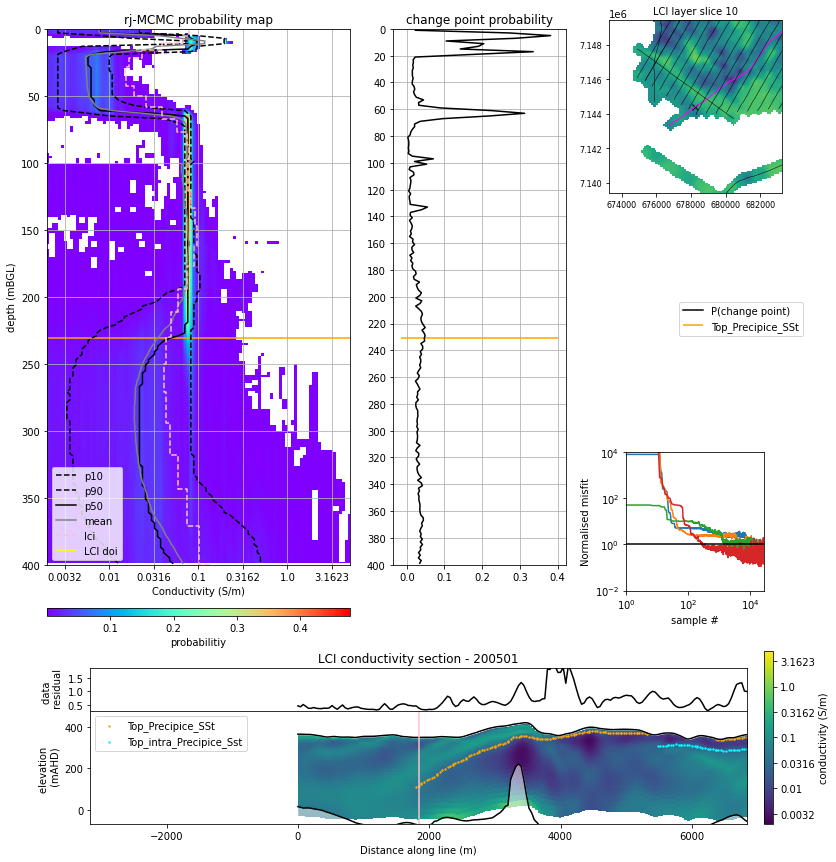

In [26]:
# Here we plot a single pmap plot

# define our point from the points array using the index i
point_index = 1

# Extract the data from the netcdf data
D = netcdf_utils.extract_rj_sounding(rj, lci, point_index)

# print the poit index and fiducial for our reference
print("rj point index is ", point_index)
print("Fidicial is ", D['fiducial'])

# create the figure
fig, ax_array = pmap_plot(D, pmap_kwargs, lci)

fname = str(D['fiducial']) + '_' + str(D['line']) + '_pmap.png'


# show the plot
plt.show()

plt.close('all')

In [154]:
# produce pmaps in batch
outdir = r"C:\temp\pmap_plots"

if not os.path.exists(outdir):
    os.mkdir(outdir)

for i in range(rj.data.dimensions['point'].size):
    generate_pmap_plots(i)



In [15]:
easting = df_conductance['easting'].values
northing = df_conductance['northing'].values
geometry = []
for i in range(len(easting)):
    geometry.append(Point(easting[i], northing[i]))

df_conductance['geometry'] = geometry

In [25]:
# break into percentiles

for item in ['p10', 'p50', 'p90']:
    mask = df_conductance['percentile'] == item
    gdf = gpd.GeoDataFrame(df_conductance[mask],
                           crs = 'EPSG:28355')

    gdf.to_file(r"C:\temp\Surat_conductance" + item + ".shp")